# Assignment:
In this Jupyter Notebook you find the answer to the asked question that follows:

<div style="border: 1px solid #ddd; border-radius: 5px; padding: 10px; background-color: #f9f9f9;">

With the data provided we would like to ask you to implement a ML classification model and provide the code necessary to train it from scratch. We are not asking for a model with any specific capabilities or performance, it is up to you to explore the problem and assess what could be reasonable and interesting within the given time constraints, taking design decisions accordingly. We'd like you to analyse the problem and give us some insights. The insights should be useful and actionable in some way.
    
We ask data scientist do want to join Idoven to work with anonymised patient data, and on the basis of this data be able to:

- Read the ECG files and corresponding annotations
- Show how they will work on the signal and plot the signal in appropriate manner to be read by a doctor
  
As a result we expect a github project with and extructure that will include:

- Reference documentation used
- **Jupyter Notebook** (this notebook), in an running environment, Colab, Docker.
- An explanation of the work done and lessons learned.

</div>
<br/><br/>

The structure of this Jupyter Notebook is as follow:
- **Exploratory Data Analysis (EDA)**: to understand the data and its properties (ECG files, signals, annotations, plots, data processing)
- **ML classification**: runnable script to train and evaluate the trained model. The code is provided as Jupyter Notebook which calls methods and modules from *.py* file to maintain verbosity on main actions
- **Conclusion**: discussion on the work done, lessons learned and possible future works. In this section a list of references is provided.  

## Exploratory Data Analysis (EDA)

#### Import libraries

In [1]:
import pandas as pd
import numpy as np
import os
import wfdb
import ast
import ecg_plot
from tqdm import tqdm
import warnings; warnings.filterwarnings('ignore')
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
## Defining functions as in example_physionet.py

def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in tqdm(df.filename_lr)]
    else:
        data = [wfdb.rdsamp(path+f) for f in tqdm(df.filename_hr)]
    data = np.array([signal for signal, meta in data])
    return data

In [48]:
# path = '/content/drive/MyDrive/ModelData/data/ptbxl/' -- get dataset from mounted drive account (relatively slow)
path = '../data/ptbxl/'
sampling_rate=100

# load and convert annotation data
Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

# Load raw signal data
X = load_raw_data(Y, sampling_rate, path)


100%|██████████| 21837/21837 [00:55<00:00, 395.37it/s]


### Analyse CSVs


#### Annotation data
CSV file with patient's information, annotations and metadata

In [50]:
# Total number of rows and columns
print(f"Training Set:\nNumber of Rows: {Y.shape[0]}, Number of Columns: {Y.shape[1]}")
Y.head()

Training Set:
Number of Rows: 21837, Number of Columns: 27


,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
ecg_id,,,,,,,,,,,,,,,,,,,,,
1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,...,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,...,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,...,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr


In [51]:
Y.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21837 entries, 1 to 21837
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   patient_id                    21837 non-null  float64
 1   age                           21748 non-null  float64
 2   sex                           21837 non-null  int64  
 3   height                        6983 non-null   float64
 4   weight                        9429 non-null   float64
 5   nurse                         20328 non-null  float64
 6   site                          21819 non-null  float64
 7   device                        21837 non-null  object 
 8   recording_date                21837 non-null  object 
 9   report                        21837 non-null  object 
 10  scp_codes                     21837 non-null  object 
 11  heart_axis                    13332 non-null  object 
 12  infarction_stadium1           5626 non-null   object 
 13  infarc

We have 27 columns with different data types. We can see that there are null values for several columns (we'll look at it later)


**Descriptive Analysis**

In [52]:
print("Dataset Descriptive Analysis for numerical values.")
Y.describe().transpose()

Dataset Descriptive Analysis for numerical values.


,count,mean,std,min,25%,50%,75%,max
patient_id,21837.0,11255.005953,6234.132489,302.0,5982.0,11423.0,16614.0,21797.0
age,21748.0,59.836307,16.953125,2.0,50.0,62.0,72.0,95.0
sex,21837.0,0.478912,0.499567,0.0,0.0,0.0,1.0,1.0
height,6983.0,166.708292,10.864935,6.0,160.0,166.0,174.0,209.0
weight,9429.0,70.997561,15.875146,5.0,60.0,70.0,80.0,250.0
nurse,20328.0,2.292503,3.254786,0.0,0.0,1.0,3.0,11.0
site,21819.0,1.547229,4.169753,0.0,0.0,1.0,2.0,50.0
validated_by,12426.0,0.747948,1.183269,0.0,0.0,1.0,1.0,11.0
strat_fold,21837.0,5.505335,2.875306,1.0,3.0,6.0,8.0,10.0


We can see that, as anticipated by the README.md in folder **data** male and female are almost the same percentage (balanced).\
The mean age is ~60 yo. with a std ~16, and the median value is 62yo.\
The height and weight have several missing values.

**Missing values**

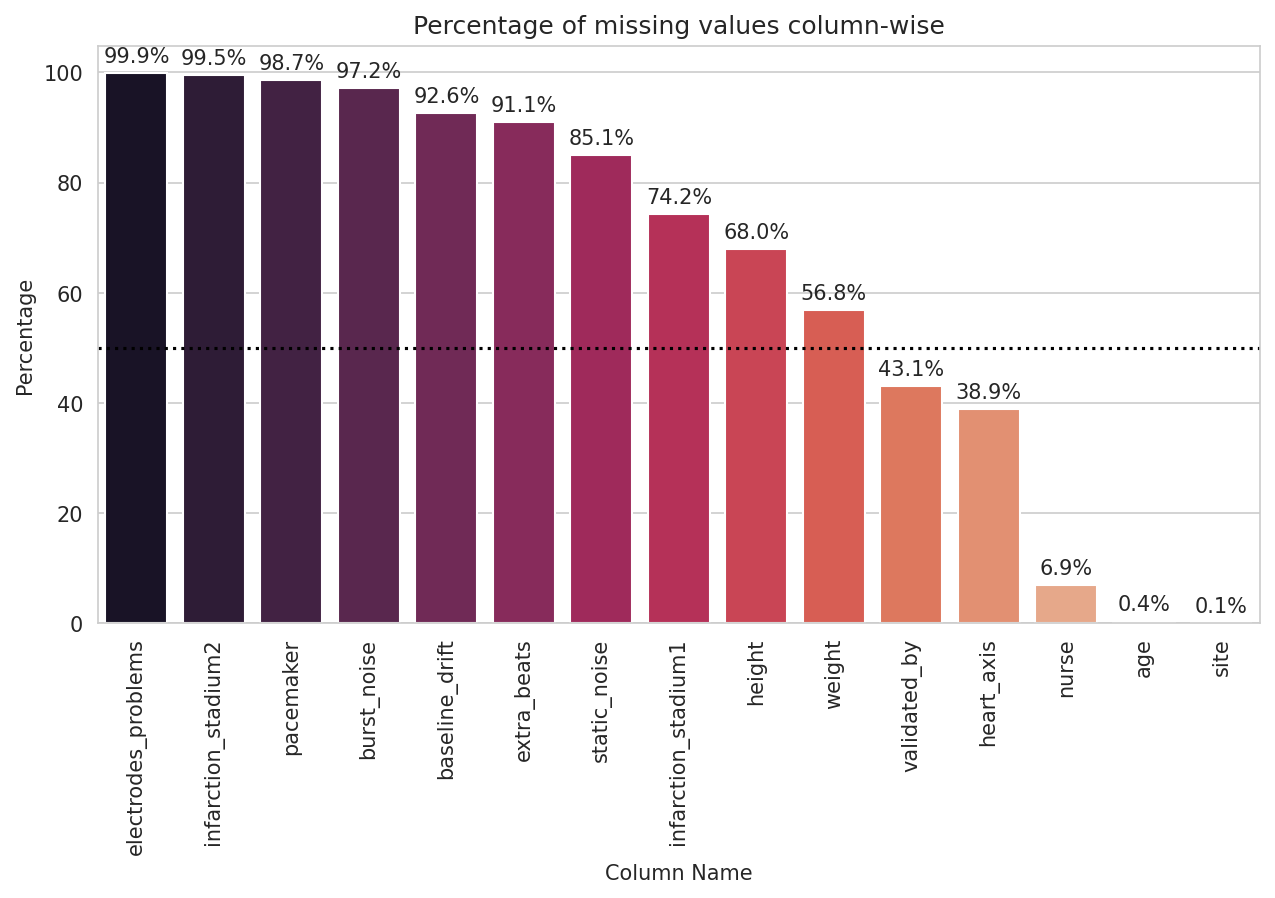

In [53]:
# Calculate percentage of missing values
null_values = Y.isnull().sum().sort_values(ascending=False)
percent = (Y.isnull().sum() / len(Y)) * 100
percent = percent[percent > 0].sort_values(ascending=False)

# Plotting
plt.figure(figsize=(10,5 ), dpi=150)
ax = sns.barplot(x=percent.index, y=percent, palette="rocket")

# Add percentage values above the bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.1f}%', 
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center',
                xytext=(0, 8), textcoords='offset points')

# Add horizontal dotted line at y=50
plt.axhline(50, color='black', linestyle='dotted')

# Set axis labels
plt.xlabel('Column Name')
plt.ylabel('Percentage')
plt.title('Percentage of missing values column-wise')
# Rotate x-axis labels
plt.xticks(rotation=90)

# Display the plot
plt.show()


**Correlations**

Pearson's correlation to check linear correletion among numerical variables.

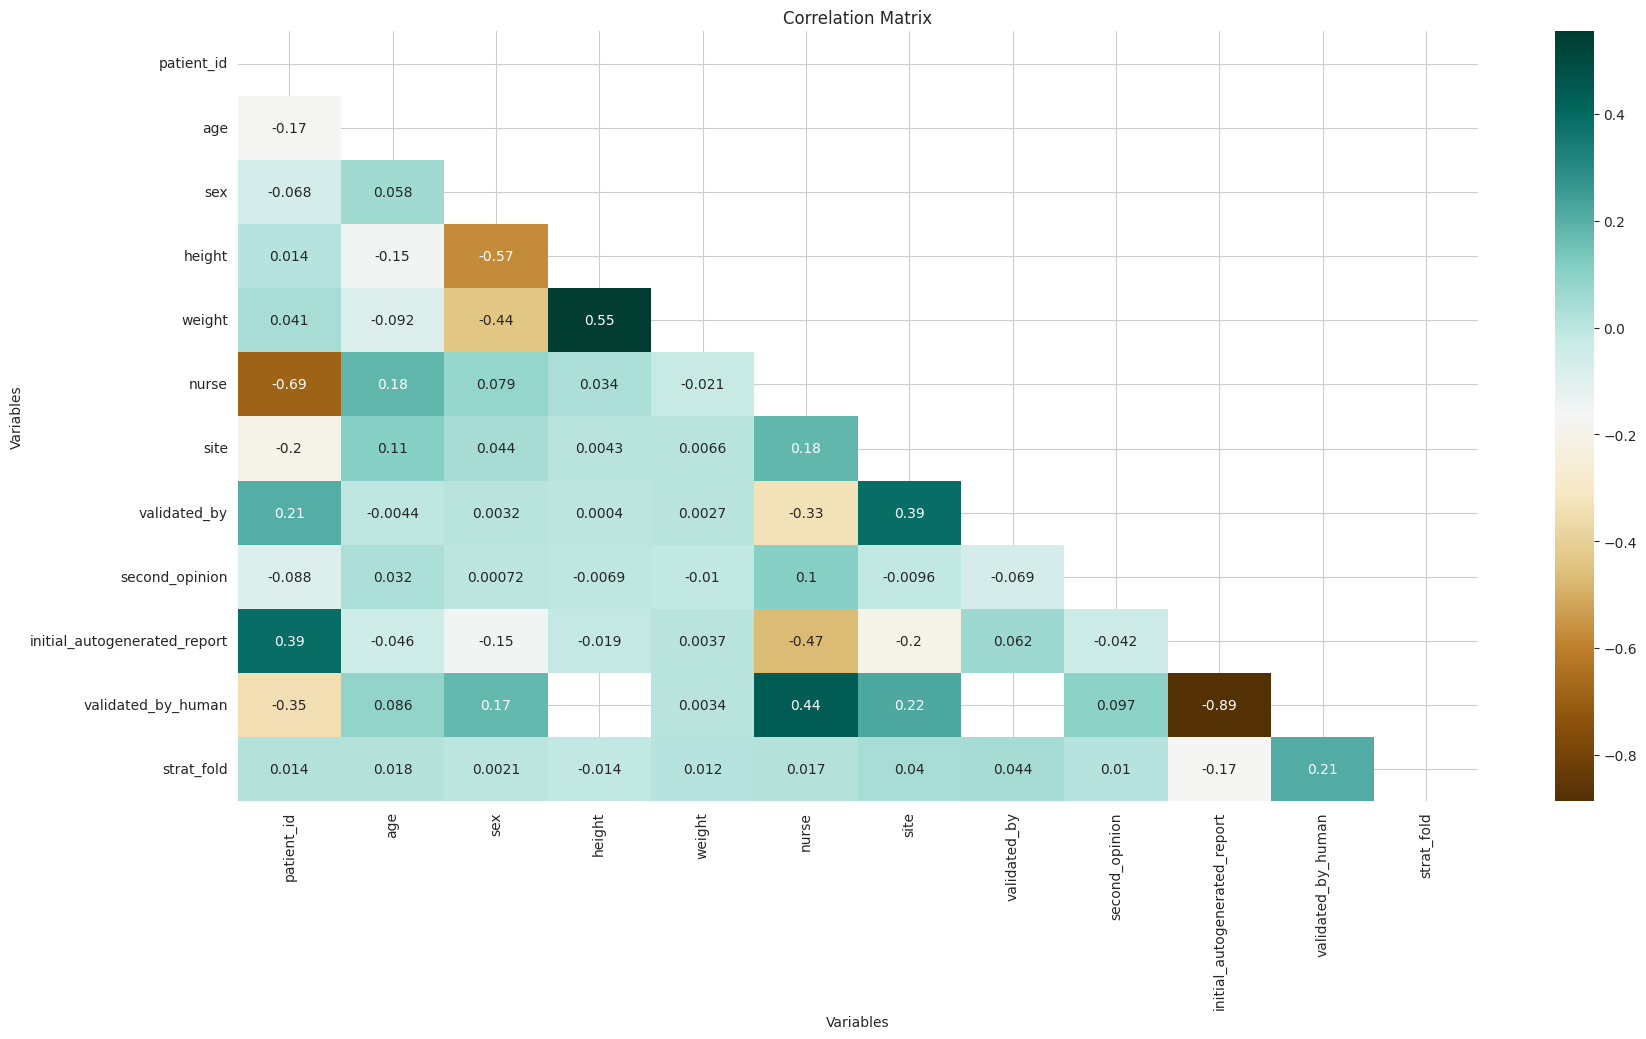

In [54]:
# Convert appropriate columns to numeric, using errors='coerce' to handle errors
Y_numeric = Y.apply(pd.to_numeric, errors='coerce')

# Drop columns that were fully converted to NaN due to non-numeric values
Y_numeric = Y_numeric.dropna(axis=1, how='all')

# Compute the correlation matrix
corr_matrix = Y_numeric.corr()

# Mask to only show upper triangle
mask = np.triu(corr_matrix)

# Plotting the heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(corr_matrix, cmap="BrBG", annot=True, mask=mask)
plt.xlabel('Variables')
plt.ylabel('Variables')
plt.title('Correlation Matrix')
plt.show()

Considering the correlation of clinical metadata (such as *age, sex, weight* and *height*) we can see that height and weight are negative linearly correlated with *gender* variable (male are encoded as 0 and female as 1). This negative correlation between gender-height and gender-weigth suggests that males are, on average, taller and heavier than females. On the other hand, there is a positive linear correlation between height and weight that suggest that, on average, taller patients are also heavier.

#### Diagnostic Data
Load *scp_statements.csv*, explore the diagnostic values and perform aggregation.

In [55]:
# Load 
state_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
print(f"Loaded dataset length: {len(state_df)}")
diag_df = state_df[state_df.diagnostic == 1] # keep value with diagnostic
print(f"Diagnosis in dataset: {len(diag_df)}")
diag_df.head()

Loaded dataset length: 71
Diagnosis in dataset: 44


,description,diagnostic,form,rhythm,diagnostic_class,diagnostic_subclass,Statement Category,SCP-ECG Statement Description,AHA code,aECG REFID,CDISC Code,DICOM Code
NDT,non-diagnostic T abnormalities,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,non-diagnostic T abnormalities,NaN,NaN,NaN,NaN
NST_,non-specific ST changes,1.0,1.0,NaN,STTC,NST_,Basic roots for coding ST-T changes and abnorm...,non-specific ST changes,145.0,MDC_ECG_RHY_STHILOST,NaN,NaN
DIG,digitalis-effect,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,suggests digitalis-effect,205.0,NaN,NaN,NaN
LNGQT,long QT-interval,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,long QT-interval,148.0,NaN,NaN,NaN
NORM,normal ECG,1.0,NaN,NaN,NORM,NORM,Normal/abnormal,normal ECG,1.0,NaN,NaN,F-000B7


In [56]:
print(f"{diag_df.diagnostic_class.nunique()} unique values for diagnostic_class: {(diag_df.diagnostic_class.unique())}")
print(f"{diag_df.diagnostic_subclass.nunique()} unique values for diagnostic_subclass: {(diag_df.diagnostic_subclass.unique())}")


5 unique values for diagnostic_class: ['STTC' 'NORM' 'MI' 'HYP' 'CD']
23 unique values for diagnostic_subclass: ['STTC' 'NST_' 'NORM' 'IMI' 'AMI' 'LVH' 'LAFB/LPFB' 'ISC_' 'IRBBB' '_AVB'
 'IVCD' 'ISCA' 'CRBBB' 'CLBBB' 'LAO/LAE' 'ISCI' 'LMI' 'RVH' 'RAO/RAE'
 'WPW' 'ILBBB' 'SEHYP' 'PMI']


We can see that there are the 5 *diagnostic_classes* as described in the problem statement, and 23 subclasses. Let's aggregate them in the annotation dataframe.

#### Aggregate diagnostic data with annotation data

Aggregate the information and then analyze the distribution onf variables wrt diagnosis.

**Diagnostic Superclass**

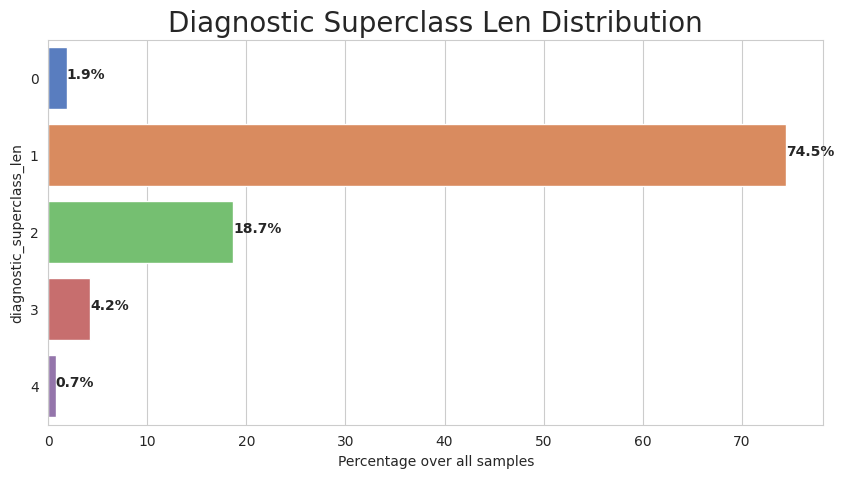

In [57]:
def aggregate_supclass_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))
    
# Apply diagnostic superclass
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_supclass_diagnostic)
Y['diagnostic_superclass_len'] = Y['diagnostic_superclass'].apply(len)
Y.loc[Y.diagnostic_superclass_len > 1, 'diagnostic_superclass']

## Now plot the percentage len among sample

vc = Y['diagnostic_superclass_len'].value_counts()

sns.set_style("whitegrid")
bar,ax = plt.subplots(figsize=(10,5))
ax = sns.barplot(x=vc.values/vc.values.sum()*100., y=vc.index, ci=None, palette="muted",orient='h' )
ax.set_title("Diagnostic Superclass Len Distribution", fontsize=20)
ax.set_xlabel ("Percentage over all samples")
ax.set_ylabel ("diagnostic_superclass_len")
for rect in ax.patches:
    ax.text (rect.get_width(), rect.get_y() + rect.get_height() / 2,"%.1f%%"% rect.get_width(), weight='bold' )

**Diagnosti Subclass**

Do the same for subclasses

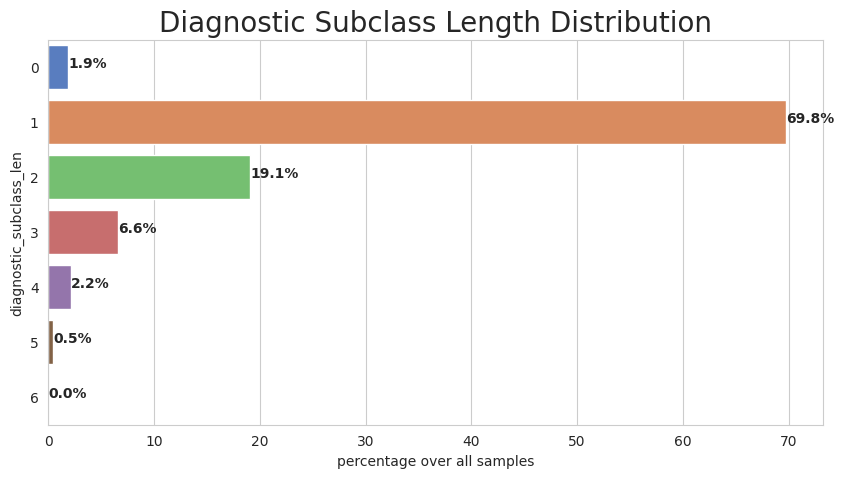

In [58]:
def aggregate_subclass_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_subclass)
    ret = list(set(tmp))
    ret = ['sub_'+r for r in ret] # to distinguish between subclass and superclass columns
    return ret

# Apply diagnostic subclass
Y['diagnostic_subclass'] = Y.scp_codes.apply(aggregate_subclass_diagnostic)
Y['diagnostic_subclass_len'] = Y['diagnostic_subclass'].apply(len)
Y.loc[Y.diagnostic_subclass_len > 1, 'diagnostic_subclass']

vc = Y['diagnostic_subclass_len'].value_counts()

sns.set_style("whitegrid")
bar,ax = plt.subplots(figsize=(10,5))
ax = sns.barplot(x=vc.values/vc.values.sum()*100., y=vc.index, ci=None, palette="muted",orient='h' )
ax.set_title("Diagnostic Subclass Length Distribution", fontsize=20)
ax.set_xlabel ("percentage over all samples")
ax.set_ylabel ("diagnostic_subclass_len")
for rect in ax.patches:
    ax.text (rect.get_width(), rect.get_y() + rect.get_height() / 2,"%.1f%%"% rect.get_width(), weight='bold' )

#### Distribution analysis

In [59]:
## Functions
class ClassUpdate():
    def __init__(self, cols):
        self.cols = cols

    def __call__(self, row):
        for sc in row['diagnostic_superclass']:
            row[sc] = 1
        for sc in row['diagnostic_subclass']:
            row[sc] = 1
            
        return row

def get_data_by_folds(folds, x, y, update_cols, feature_cols):
    assert len(folds)  > 0, '# of provided folds should longer than 1'
    #print(y.strat_fold)
    filt = np.isin(y.strat_fold.values, folds)
    x_selected = x[filt]
    y_selected = y[filt]
    
    for sc in update_cols:
        y_selected[sc] = 0
        
    cls_updt = ClassUpdate(update_cols)
    
    y_selected = y_selected.apply(cls_updt, axis=1)
    
    return x_selected, y_selected[list(feature_cols)+list(update_cols)+['strat_fold']]


In [78]:
all_superclass = pd.Series(np.concatenate(Y['diagnostic_superclass'].values))
superclass_cols = all_superclass.unique()
all_subclass = pd.Series(np.concatenate(Y['diagnostic_subclass'].values))
subclass_cols = all_subclass.unique()
update_cols = np.concatenate([superclass_cols, subclass_cols]) # concatenate subclass and superclass

meta_cols = ['age', 'sex', 'height', 'weight'] # add more columns as features


In [79]:
x_all, y_all = get_data_by_folds(np.arange(1, 11), X, Y, update_cols, meta_cols)
y_all.head()

,age,sex,height,weight,NORM,MI,STTC,HYP,CD,sub_NORM,...,sub_ISC_,sub_SEHYP,sub_ISCI,sub_CRBBB,sub_CLBBB,sub_LAO/LAE,sub_ILBBB,sub_WPW,sub_PMI,strat_fold
ecg_id,,,,,,,,,,,,,,,,,,,,,
1,56.0,1,NaN,63.0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,3
2,19.0,0,NaN,70.0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,2
3,37.0,1,NaN,69.0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5
4,24.0,0,NaN,82.0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,3
5,19.0,1,NaN,70.0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4


**Superclass distribution**

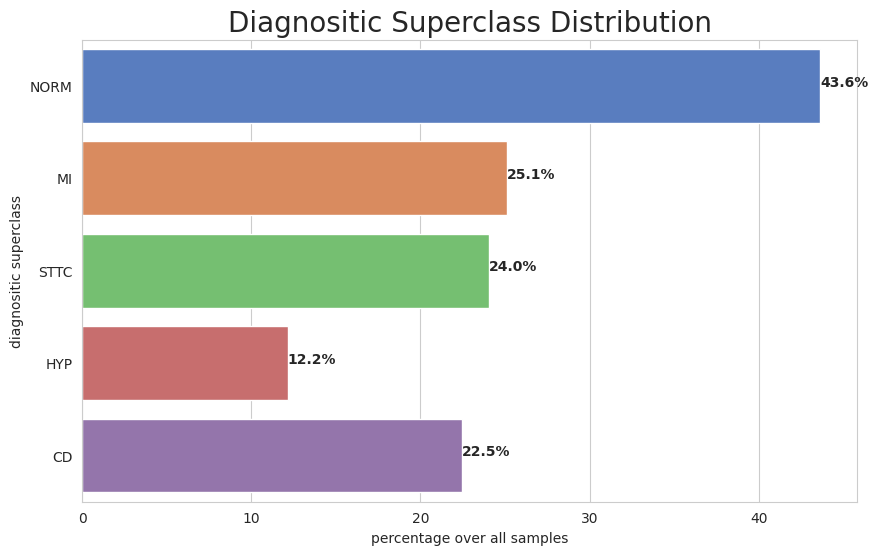

In [80]:
vc = y_all[superclass_cols].sum(axis=0)

sns.set_style("whitegrid")
bar,ax = plt.subplots(figsize=(10,6))
ax = sns.barplot(x=vc.values/y_all.shape[0]*100., y=vc.index, ci=None, palette="muted",orient='h' )
ax.set_title("Diagnositic Superclass Distribution", fontsize=20)
ax.set_xlabel ("percentage over all samples")
ax.set_ylabel ("diagnositic superclass")
for rect in ax.patches:
    ax.text (rect.get_width(), rect.get_y() + rect.get_height() / 2,"%.1f%%"% rect.get_width(), weight='bold' )

**Subclass distribution**

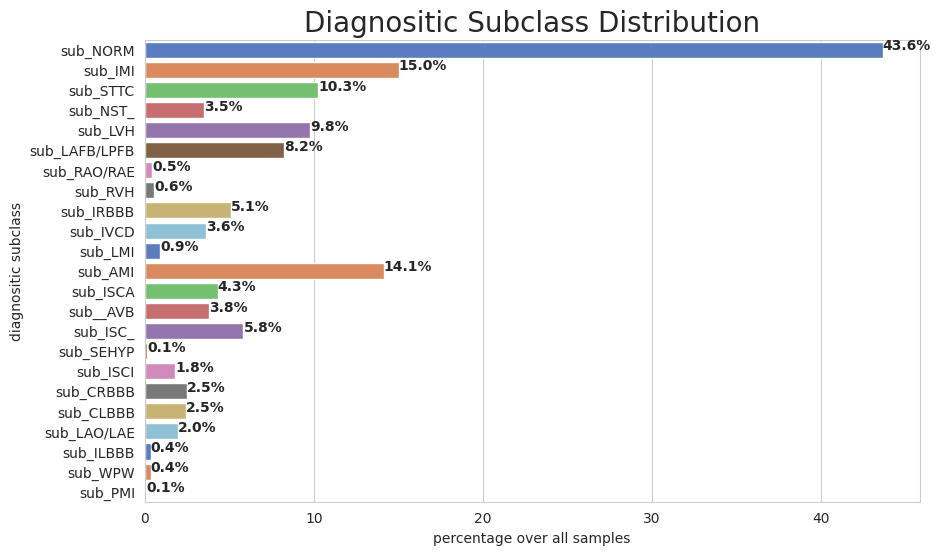

In [81]:
vc = y_all[subclass_cols].sum(axis=0)

sns.set_style("whitegrid")
bar,ax = plt.subplots(figsize=(10,6))
ax = sns.barplot(x=vc.values/y_all.shape[0]*100., y=vc.index, ci=None, palette="muted",orient='h' )
ax.set_title("Diagnositic Subclass Distribution", fontsize=20)
ax.set_xlabel ("percentage over all samples")
ax.set_ylabel ("diagnositic subclass")
for rect in ax.patches:
    ax.text (rect.get_width(), rect.get_y() + rect.get_height() / 2,"%.1f%%"% rect.get_width(), weight='bold' )
    

**Subclass distribution within superclass**

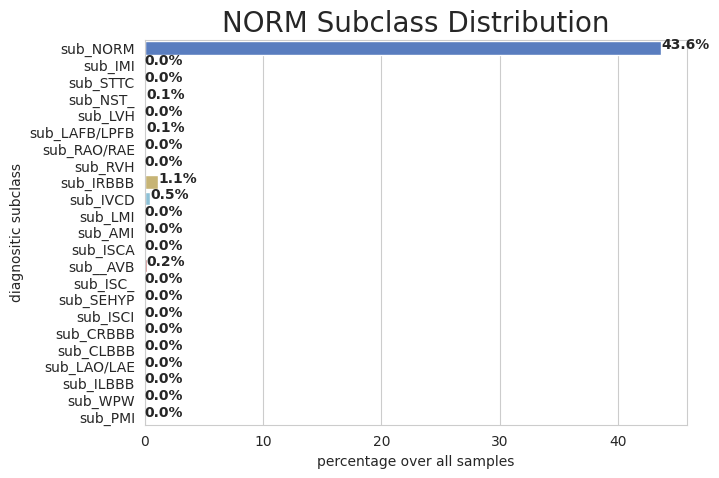

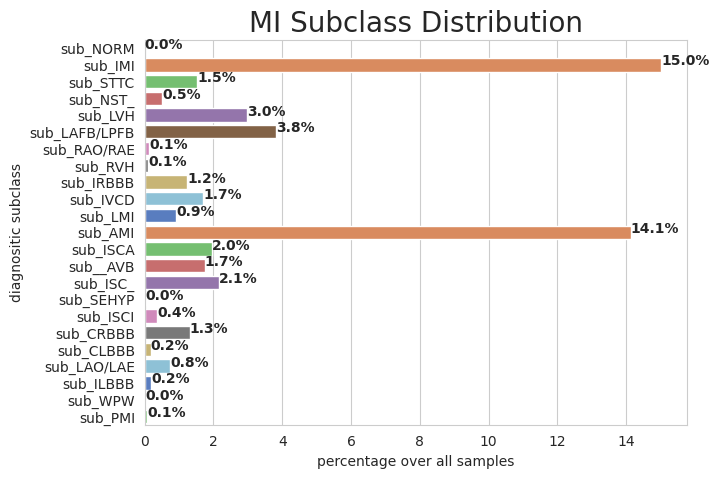

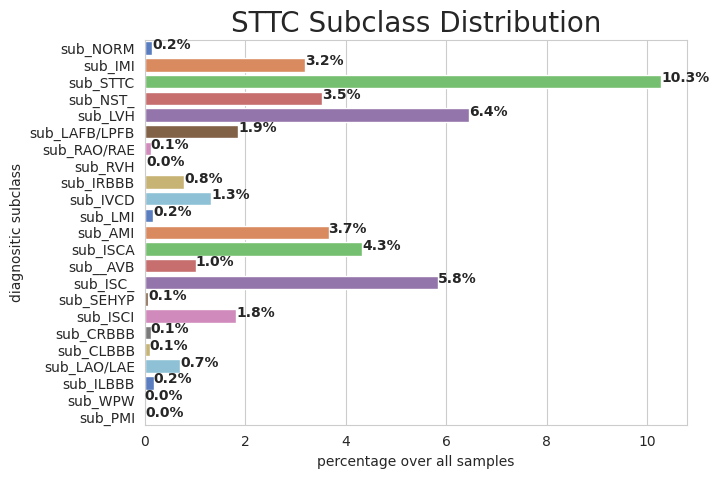

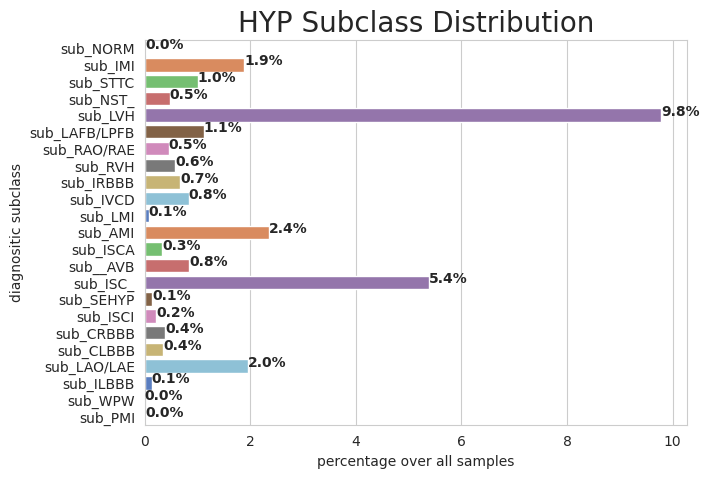

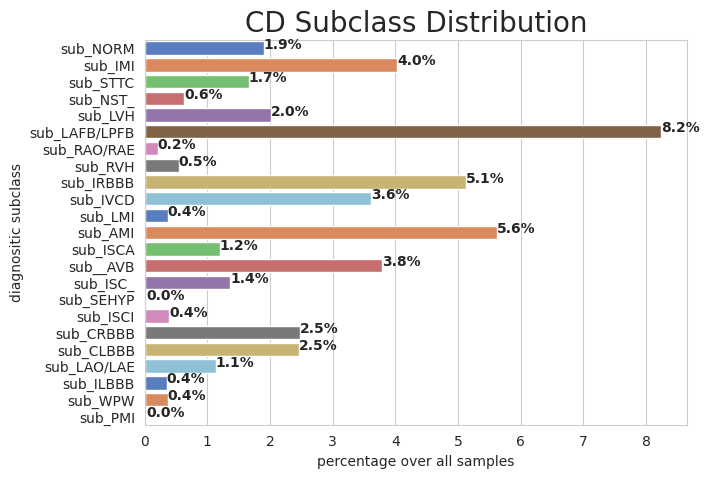

In [82]:
for superclass in superclass_cols:
    
    vc = y_all.loc[y_all[superclass] == 1][subclass_cols].sum(axis=0)
    
    sns.set_style("whitegrid")
    bar,ax = plt.subplots(figsize=(7,5))
    ax = sns.barplot(x=vc.values/y_all.shape[0]*100., y=vc.index, ci=None, palette="muted",orient='h' )
    ax.set_title("{} Subclass Distribution".format(superclass), fontsize=20)
    ax.set_xlabel ("percentage over all samples")
    ax.set_ylabel ("diagnositic subclass")
    for rect in ax.patches:
        ax.text (rect.get_width(), rect.get_y() + rect.get_height() / 2,"%.1f%%"% rect.get_width(), weight='bold' )

**Vabiable distributions among superclasses**

 - **Numerical variables**

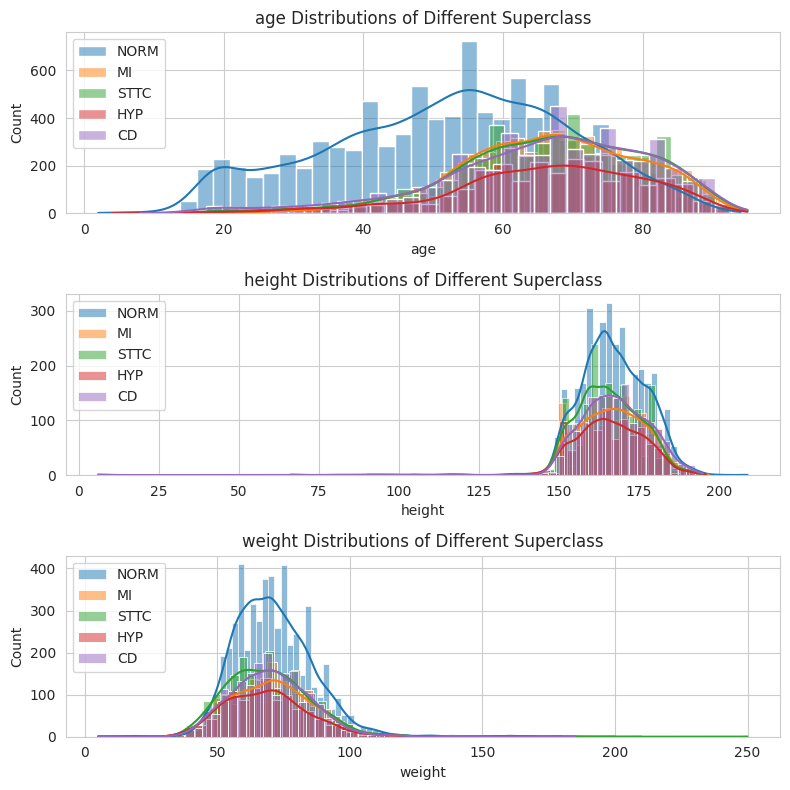

In [86]:
variables_to_plot = ['age', 'height', 'weight']
fig, axes = plt.subplots(len(variables_to_plot), 1, figsize=(8, 8))  # Adjust the figsize for better spacing

for i, variable in enumerate(variables_to_plot):
    axes[i].set_title(f'{variable} Distributions of Different Superclass')
    
    for superclass in superclass_cols:
        data = y_all.loc[y_all[superclass] == 1][variable]   
        sns.histplot(data, label=superclass, kde=True, ax=axes[i])
    
    axes[i].legend(loc='upper left')

plt.tight_layout()
plt.show()

The weight and height distributions appear visually similar across different superclasses. However, the age distribution for the NORM superclass seems slightly left-skewed. To assess the statistical significance of these observations, we can perform statistical tests such as the Kolmogorov-Smirnov (KS) test or t-tests. Additionally, other appropriate tests include the Mann-Whitney U test for non-parametric data, ANOVA for comparing means across multiple groups, and the Chi-square test for categorical variables.

In [97]:
from scipy.stats import ks_2samp, ttest_ind, mannwhitneyu


# Remove rows with NaN values for the relevant variables
y_all_cleaned = y_all.dropna(subset=variables_to_plot + list(superclass_cols))

# Performing statistical tests
for variable in variables_to_plot:
    print(f'\nStatistical tests for {variable}:')

    superclass_pairs = [(superclass_cols[i], superclass_cols[j]) 
                        for i in range(len(superclass_cols)) 
                        for j in range(i + 1, len(superclass_cols))]
    
    for pair in superclass_pairs:
        data1 = y_all_cleaned.loc[y_all_cleaned[pair[0]] == 1][variable]
        data2 = y_all_cleaned.loc[y_all_cleaned[pair[1]] == 1][variable]
        
        ks_stat, ks_p_value = ks_2samp(data1, data2)
        ttest_stat, ttest_p_value = ttest_ind(data1, data2)
        mannwhitney_stat, mannwhitney_p_value = mannwhitneyu(data1, data2)
        
        print(f'{pair[0]} vs {pair[1]}:')
        print(f'  KS test: stat={ks_stat:.4f}, p-value={ks_p_value:.4e}')
        print(f'  t-test: stat={ttest_stat:.4f}, p-value={ttest_p_value:.4e}')
        print(f'  Mann-Whitney U test: stat={mannwhitney_stat:.4f}, p-value={mannwhitney_p_value:.4e}')



Statistical tests for age:
NORM vs MI:
  KS test: stat=0.4113, p-value=1.5091e-142
  t-test: stat=-30.9426, p-value=1.1141e-190
  Mann-Whitney U test: stat=946237.5000, p-value=7.4895e-186
NORM vs STTC:
  KS test: stat=0.3862, p-value=3.1863e-153
  t-test: stat=-31.6726, p-value=1.2402e-200
  Mann-Whitney U test: stat=1391398.5000, p-value=9.1662e-197
NORM vs HYP:
  KS test: stat=0.3991, p-value=5.2000e-108
  t-test: stat=-25.2872, p-value=2.6434e-131
  Mann-Whitney U test: stat=746018.0000, p-value=1.2644e-135
NORM vs CD:
  KS test: stat=0.3750, p-value=1.6104e-126
  t-test: stat=-27.0739, p-value=5.7842e-150
  Mann-Whitney U test: stat=1193861.5000, p-value=3.4318e-157
MI vs STTC:
  KS test: stat=0.0410, p-value=1.4610e-01
  t-test: stat=2.5424, p-value=1.1056e-02
  Mann-Whitney U test: stat=1245953.5000, p-value=9.2140e-02
MI vs HYP:
  KS test: stat=0.0342, p-value=5.0556e-01
  t-test: stat=1.6987, p-value=8.9510e-02
  Mann-Whitney U test: stat=671052.5000, p-value=5.0941e-01
MI vs

So, as noticed visually the NORM vs other classes for Age distributions resulted in:
- NORM vs MI:
  - Mann-Whitney U test: stat=946237.5000, p-value=7.4895e-186
- NORM vs STTC:
  - Mann-Whitney U test: stat=1391398.5000, p-value=9.1662e-197
- NORM vs HYP:
  - Mann-Whitney U test: stat=746018.0000, p-value=1.2644e-135
- NORM vs CD:
  - Mann-Whitney U test: stat=1193861.5000, p-value=3.4318e-157

all have a p-value < 0.005 which means that the differences between distribution has statistical significance and cannot be assessed only to randomness.

- **Categorical variables**

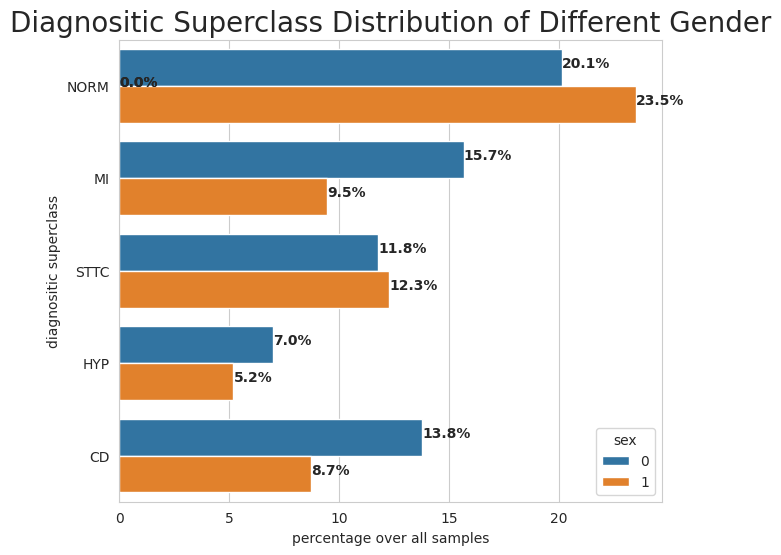

In [84]:
sns.set_style("whitegrid")
bar,ax = plt.subplots(figsize=(7,6))
    
ax.set_title("Diagnositic Superclass Distribution of Different Gender", fontsize=20)

all_index, all_count, all_values = [], [], []
for sex in y_all.sex.unique():
    vc = y_all.loc[y_all.sex == sex][superclass_cols].sum(axis=0)
    all_index += list(vc.index)
    all_count += list(vc.values/y_all.shape[0]*100.)
    all_values += [sex]*len(vc)
    #print(all_sex)
    
df = pd.DataFrame()
df['diagnositic superclass'] = all_index
df['percentage over all samples'] = all_count
df['sex'] = all_values
    
ax = sns.barplot(data=df, x="percentage over all samples", y="diagnositic superclass", hue="sex",ci=None, orient='h')
for rect in ax.patches:
    ax.text (rect.get_width(), rect.get_y() + rect.get_height() / 2,"%.1f%%"% rect.get_width(), weight='bold')

Again, here we can perform Chi-square test for categorical variables to asses the comparison among distributions. 